## Downstream Task: Pascal

Now that we've pretrained a network to fill in image patches, let's create a task that will allow us to benchmark how well our pretext task works. We can imagine a variety of downstream tasks including segmentation, objection detection and classification across a range of image distributions including natural photographs or medical images.

To keep things simple for now, we'll just try image classification on the Pascal VOC dataset.

In [13]:
import json

from collections import Set
import numpy as np
import pandas as pd

from fastai2.basics import DataBlock, RandomSplitter

from fastai2.vision.all import ImageBlock, PILMask, get_image_files, PILImage, imagenet_stats
from fastai2.vision.core import get_annotations, Image, TensorBBox, TensorPoint, TensorImage
from fastai2.vision.augment import aug_transforms, RandomResizedCrop, RandTransform
from fastai2.vision.learner import unet_learner, unet_config

from fastai2.vision.data import ImageDataBunch
from fastai2.data.block import MultiCategoryBlock
from fastai2.data.transforms import Normalize
from fastai2.data.external import download_url, URLs, untar_data

from torch.nn import MSELoss
from torchvision.models import resnet34

In [14]:
pascal_path = untar_data(URLs.PASCAL_2012)
pascal_path

Path('/home/josh/.fastai/data/pascal_2012')

In [15]:
train_json = json.load(pascal_path/'train.json')

In [16]:
IMAGES,ANNOTATIONS,CATEGORIES = 'images', 'annotations', 'categories'
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

# Create a map from category ID to the category's string name
cats = {o[ID]:o['name'] for o in train_json[CATEGORIES]}
# Create a map from image ID to image file name
trn_fns = {o[ID]:o[FILE_NAME] for o in train_json[IMAGES]}

In [68]:
# We map each object to the set of classes contained in that object
image_to_category = {}
for annotation in train_json[ANNOTATIONS]:
    img_id = annotation['image_id']
    category_id = annotation['category_id']
    filename = trn_fns[img_id]
    
    if filename not in image_to_category:
        image_to_category[filename] = set()
        
    image_to_category[filename].add(cats[category_id])
    
# Now we join the set of classes present in an image into a single comma-delimited string
# We do this because it's easier to work with multilabel data in fastai this way
image_to_category = [(k, ','.join(v)) for k, v in image_to_category.items()]
image_to_category[:5]    

[('2008_000008.jpg', 'horse,person'),
 ('2008_000015.jpg', 'bottle'),
 ('2008_000019.jpg', 'dog'),
 ('2008_000023.jpg', 'bottle,tvmonitor,person'),
 ('2008_000028.jpg', 'car')]

In [57]:
train_df = pd.DataFrame(image_to_category)

In [58]:
data = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter())

In [61]:
databunch = ImageDataBunch.from_df(train_df, 
                                   path=pascal_path/'train',
                                   fn_col=0,
                                   bs=8,
                                   item_tfms=[RandomResizedCrop(160)], #TODO: Not crop, just resize
                                   batch_tfms=[*aug_transforms(size=160, max_warp=0, max_rotate=0)],
                                   label_delim=','
                                  )
                                  

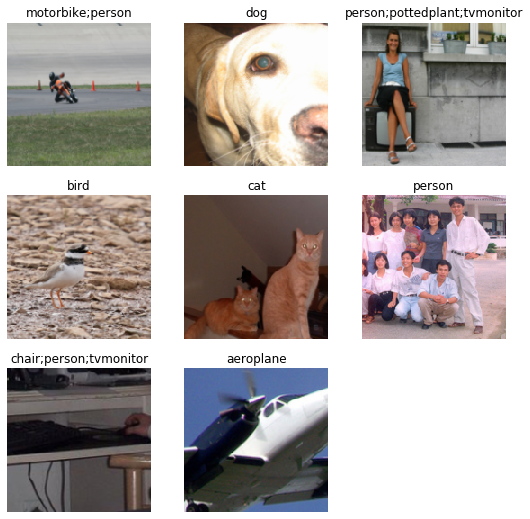

In [62]:
databunch.show_batch(max_n=9)

In [13]:
# TODO Load learner that was trained on pretext task

In [14]:
# TODO fine tune on this task

In [15]:
# TODO gauge performance